In [55]:
# Load necessary libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
from math import ceil
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Flag to avoid re-running certain sections, Combining the bins and segments. Takes a while otherwise
already_done = True

## Methods

Copy number alterations were detected using a modified off-target sequencing pipeline based on the QDNAseq framework. The analysis pipeline consisted of several key steps:

**Read Count Extraction and Binning:** Sequencing reads from tumor and matched normal BAM files were binned into genomic intervals, excluding regions overlapping with target capture regions to focus on off-target coverage. Sex chromosomes were handled appropriately based on sample sex determination (automatic or user-specified), with Y chromosome bins excluded for female samples.

**Normalization and Bias Correction:** Tumor read counts were normalized against matched normal samples by calculating log2 ratios of tumor-to-normal read counts per bin. Technical biases were corrected using LOESS regression to adjust for GC content and mappability effects. Bins with insufficient coverage (< 10 reads in normal samples) were excluded from analysis.

**Segmentation:** Copy number segmentation was performed using the Piecewise Constant Fitting (PCF) algorithm from the Battenberg package, applied chromosome-wise to maintain appropriate boundaries. Segmentation parameters included a configurable gamma parameter (controlling segment sensitivity, default γ=30) and minimum segment size (k_min, configurable). Segments were summarized using either mean or median values within each segment (default: median).

**Statistical Classification:** Each segment was statistically tested for copy number alterations using two-sample t-tests comparing observed log2 ratios against null distributions representing gains (mean = +0.025) and losses (mean = -0.025). P-values were adjusted for multiple testing using Bonferroni correction, with significance threshold set at α=0.05. Large segments (>500 bins) were subsampled to prevent inflated significance from extensive data.

**Copy Number Calling:** Segments were classified as "gain," "loss," or "normal" based on adjusted p-values. Tumor purity was estimated per segment and overall using a grid search optimization approach that minimizes the error between observed log2 ratios and expected integer copy number states, assuming diploid baseline.

**Quality Control:** Outlier bins were smoothed using QDNAseq default methods, and segments failing quality metrics or showing contradictory classifications (both gain and loss) were flagged. The pipeline generated comprehensive outputs including per-bin read counts, normalized log2 ratios, segment coordinates, statistical test results, and estimated tumor purity values.

#### Parameter Testing
#### Bin and parameter testing summary

- Binning and per-bin QC
    - Binned tumour and matched-normal read counts were collected into a unified bins table. Chromosome labels were normalized (X/Y remapped where required to chromosome 20,21 respectively) and log10-transformed read-count columns were added for plotting (tumour_readcount_log10, normal_readcount_log10). 

- Per-chromosome exploratory plots and per-bin summaries
    - For each chromosome, bins were grouped into 2.5 Mb position blocks and the tumour/normal log10 read counts were converted to a long format for plotting. Violin plots comparing tumour vs normal distributions were produced per chromosome. For each chromosome a table of boxplot summary statistics per group (type × group) was written (boxplot_bin_stats_chromosome_{chrom}.csv) and a running summary of mean/median log10 read counts across chromosomes was appended to summary_bin_stats_all_chromosomes.csv. A separate CSV of per-chromosome summary statistics (medians, SDs, maxes, bin counts) was also exported (default_bins_summary_statistics_by_chromosome.csv).

- Segmentation parameter sweep
    - `k_min` (minimum segment size)
        - Definition: the minimum number of adjacent bins required to call a segment. Units are bins (not basepairs), so it depends on your bin width.
        - Effect: Increasing `k_min` prevents small, potentially spurious segments (forces calls to cover more bins). Decreasing `k_min` allows detection of shorter events but increases false positives from noise.
        - Practical trade-off: set `k_min` relative to expected event size and signal-to-noise. For shallow/off-target data a larger `k_min` reduces false positives; for focal CNAs (amplicons) use smaller `k_min`.
        - Example: `k_min = 2` allows very short segments (useful to test sensitivity), while larger values (e.g. 5–20) impose more smoothing.

    - `γ` (gamma, segmentation penalty / sensitivity)
        - Definition: a penalty parameter in PCF-like algorithms that controls how costly it is to introduce a change-point (new segment). Larger `γ` imposes a stronger penalty for adding breakpoints.
        - Effect: Small `γ` → sensitive segmentation → many short segments (potential over-segmentation). Large `γ` → conservative segmentation → fewer, larger segments (potential under-segmentation).
        - Practical trade-off: tune `γ` to balance sensitivity vs. specificity. Lower values are useful when you expect many small events or have high-quality data; higher values are useful to suppress noise-driven breakpoints.
        - Example: `γ ≈ 30` is the pipeline default here; tests at `γ = 10, 50, 100` explore more/less aggressive calling.

    - Multiple segmentation runs were compared: default (γ ≈ 30), γ = 10, γ = 50, γ = 100 and a k_min = 2 variant. Segment files are read from gzip CSVs (seg_gamma*_segments.csv.gz, K_min2_segments.csv.gz, default_all_segments.csv.gz) and concatenated into a single dataframe for joint analysis. 

- Per-sample and per-run metrics
    - Number of segments per sample was tallied and plotted as a boxplot to compare segmentation granularity across parameter settings (segment_counts_boxplot.pdf). Per-sample summaries including n_segments, median and mean segment lengths were computed to inspect run-level effects of parameter choices.

- Segment-length and class composition analyses
    - Segment lengths were binned into biologically relevant ranges (<1 Mb, 1–5 Mb, 5–10 Mb, 10–50 Mb, >50 Mb) and the length-category distribution per run was plotted as a stacked proportional barplot (segment_length_distribution_stacked_bar.pdf). Segment copy-number classes (Loss/Normal/Gain) were established from an explicit `class` column or inferred from segment log-ratio thresholds, and total segment lengths per class were aggregated per run. Proportional stacked barplots of copy-number class composition (by summed segment length) were produced (segment_copy_number_class_distribution_stacked_bar.pdf).

- Aggregation and reporting
    - Run-level aggregation used summary statistics (count/median/mean) across numeric segmentation fields (assumed ploidy, start/end, len, purity, p-values, etc.) to produce a compact comparison table of segmentation behaviours across parameter settings. All intermediate and final summary tables and figures are written to disk for reproducibility and downstream inspection.

## Load in datasets

In [56]:
def collect_and_concat(pattern, sep='\t'):
    files = list(base.rglob(f'*{pattern}'))
    if not files:
        return pd.DataFrame()
    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f, sep=sep)
        except Exception as e:
            print(f"Warning: failed to read {f}: {e}")
            continue
        df['Sample'] = f.parent.name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()



### Default Settings

In [ ]:
base = Path('DEFAULT')

# Bins
bins_out = 'default_all_bins.csv.gz'
if already_done:
    default_bins = pd.read_csv(bins_out, compression='gzip')
else:
    default_bins = collect_and_concat('readcounts.txt', sep='\t')
    # Save with gzip compression
    default_bins.to_csv(bins_out, index=False, compression='gzip')

# Segments
segs_out = 'default_all_segments.csv.gz'
if already_done:
    default_segments = pd.read_csv(segs_out, compression='gzip')
else:
    default_segments = collect_and_concat('segmentation.txt', sep='\t')
    default_segments.to_csv(segs_out, index=False, compression='gzip')

### Segmentation Gamma 10


In [ ]:
base = Path('SEG_GAMMA_10')

# Segments
segs_out = 'seg_gamma10_segments.csv.gz'
if already_done:
    default_segments = pd.read_csv(segs_out, compression='gzip')
else:
    default_segments = collect_and_concat('segmentation.txt', sep='\t')
    default_segments.to_csv(segs_out, index=False, compression='gzip')

### Segmenation K-min 2

In [ ]:
base = Path('K_MIN_2')

# Segments
segs_out = 'K_min2_segments.csv.gz'
if already_done:
    default_segments = pd.read_csv(segs_out, compression='gzip')
else:
    default_segments = collect_and_concat('segmentation.txt', sep='\t')
    default_segments.to_csv(segs_out, index=False, compression='gzip')

### Segmenation Gamma 50

In [ ]:
base = Path('SEG_GAMMA_50')

# Segments
segs_out = 'seg_gamma50_segments.csv.gz'
if already_done:
    default_segments = pd.read_csv(segs_out, compression='gzip')
else:
    default_segments = collect_and_concat('segmentation.txt', sep='\t')
    default_segments.to_csv(segs_out, index=False, compression='gzip')

### Segmentation Gamma 100

In [ ]:
base = Path('SEG_GAMMA_100')

# Segments
segs_out = 'seg_gamma100_segments.csv.gz'
if already_done:
    default_segments = pd.read_csv(segs_out, compression='gzip')
else:
    default_segments = collect_and_concat('segmentation.txt', sep='\t')
    default_segments.to_csv(segs_out, index=False, compression='gzip')

## Binned read counts

In [68]:
# ensure chromosome numeric mapping and log10 columns exist (idempotent)
if 'chromosome' in default_bins.columns:
    default_bins['chromosome'] = default_bins['chromosome'].replace({'X': 20, 'Y': 21}).astype(int)

if 'tumour_readcount_log10' not in default_bins.columns:
    default_bins['tumour_readcount_log10'] = np.log10(default_bins['tumour_readcount'] + 1)
if 'normal_readcount_log10' not in default_bins.columns:
    default_bins['normal_readcount_log10'] = np.log10(default_bins['normal_readcount'] + 1)

for chrom in range(1, 22):
    chrom_df = default_bins[default_bins['chromosome'] == chrom]
    # Add a grouping column for every 1 million bases
    chrom_df = chrom_df.copy()
    chrom_df['group'] = (chrom_df['start'] // 2_500_000) * 2_500_000
    # Calculate mean positions and mean log10 read counts for ticks
    if chrom_df.empty:
        continue
    # Melt the dataframe to long format for seaborn, add a 'type' column for tumour/normal, then have start and a count column
    long_df = pd.melt(
        chrom_df, id_vars='group', value_vars=['tumour_readcount_log10', 'normal_readcount_log10'],
        var_name='type', value_name='log10_count'
    )
    long_df['type'] = long_df['type'].map({'tumour_readcount_log10': 'Tumour', 'normal_readcount_log10': 'Normal'})

    # ensure a PdfPages is created once and reused across iterations
    pdf_path = Path('default_bins_violin_by_chromosome.pdf')
    if 'pdf' not in locals():
        pdf = PdfPages(pdf_path)

    # Create the violin plot on its own figure and save to the multipage PDF
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.violinplot(x='group', y='log10_count', hue='type', data=long_df, split=True, inner='quartile', ax=ax)
    ax.set_title(f'Chromosome {chrom}')
    ax.set_xlabel('Genomic Position (Start)')
    ax.set_ylabel('Log10 Read Count')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_size(12)
    # Ensure legend is present and not duplicated by seaborn internals
    handles, labels_ = ax.get_legend_handles_labels()
    if handles:
        ax.legend(title='Sample Type')
    else:
        ax.legend_.remove() if getattr(ax, "legend_", None) else None
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

    # Close the PDF after the final chromosome to flush to disk
    if chrom == 21 and 'pdf' in locals():
        pdf.close()

    # Save a table of boxplot stats for each chromosome per bin
    # compute boxplot stats using raw (non-log) read counts
    raw_long = pd.melt(
        chrom_df, id_vars='group', value_vars=['tumour_readcount', 'normal_readcount'],
        var_name='type', value_name='count'
    )
    raw_long['type'] = raw_long['type'].map({'tumour_readcount': 'Tumour', 'normal_readcount': 'Normal'})
    boxplot_stats = raw_long.groupby(['type', 'group'])['count'].describe()
    stats_out_path = Path(f'boxplot_bin_stats_chromosome_{chrom}.csv')
    boxplot_stats.to_csv(stats_out_path)
        
    # Generate a summary table using non-log read counts (mean, median, min, max per sample type)
    tumor_mean = chrom_df['tumour_readcount'].mean()
    tumor_median = chrom_df['tumour_readcount'].median()
    tumor_max = chrom_df['tumour_readcount'].max()

    normal_mean = chrom_df['normal_readcount'].mean()
    normal_median = chrom_df['normal_readcount'].median()
    normal_max = chrom_df['normal_readcount'].max()

    summary_counts = pd.DataFrame({
        'Chromosome': [chrom, chrom],
        'Sample Type': ['Tumour', 'Normal'],
        'Mean Read Count': [tumor_mean, normal_mean],
        'Median Read Count': [tumor_median, normal_median],
        'Min Read Count': [tumor_min, normal_min],
        'Max Read Count': [tumor_max, normal_max]
    })

    summary_out_path = Path('summary_bin_stats_all_chromosomes.csv')
    if chrom == 1:
        summary_counts.to_csv(summary_out_path, index=False, mode='w')
    else:
        summary_counts.to_csv(summary_out_path, index=False, mode='a', header=False)


In [63]:
# Calculate summary statistics for bins by chromosome
summary_stats = default_bins.groupby('chromosome').agg(
    median_tumour_readcount=('tumour_readcount', 'median'),
    std_tumour_readcount=('tumour_readcount', 'std'),
    min_tumour_readcount=('tumour_readcount', 'min'),
    max_tumour_readcount=('tumour_readcount', 'max'),
    median_normal_readcount=('normal_readcount', 'median'),
    std_normal_readcount=('normal_readcount', 'std'),
    min_normal_readcount=('normal_readcount', 'min'),
    max_normal_readcount=('normal_readcount', 'max'),
    number_of_bins=('chromosome', 'size')
).reset_index()

In [64]:
summary_stats

# Write summary statistics to CSV
summary_stats.to_csv('default_bins_summary_statistics_by_chromosome.csv', index=False)

## Segmentation

/var/folders/bl/y_b3z21x40sfgtztcxdh3zt00000gq/T/ipykernel_62895/3720378379.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_counts = all_segs.groupby(['run', 'Sample']).size().reset_index(name='num_segments')


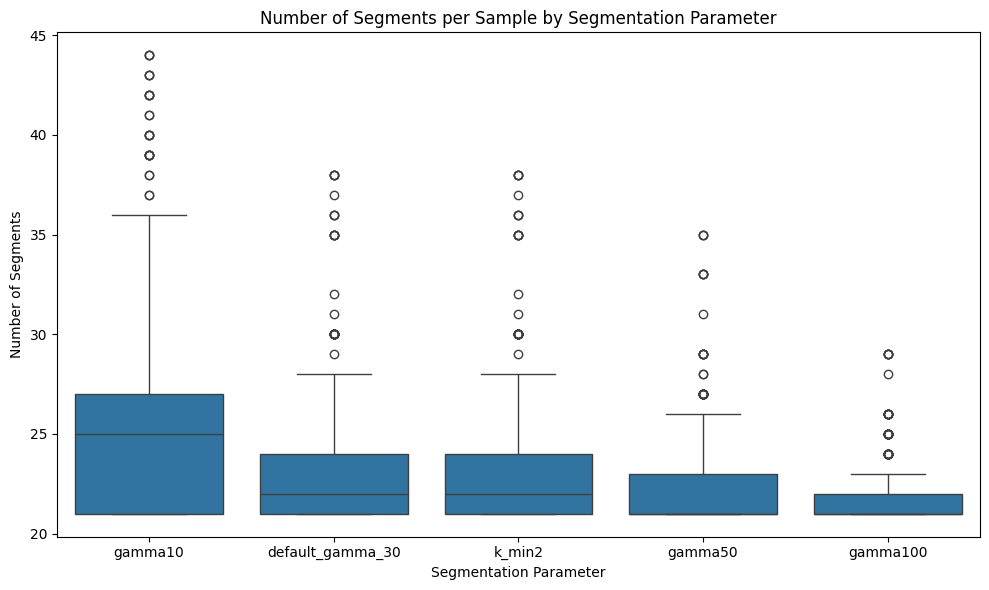

In [65]:
from pathlib import Path

# Compare the segments between different parameters
# files produced by earlier cells
seg_files = {
    'default_gamma_30': Path('default_all_segments.csv.gz'),
    'gamma10': Path('seg_gamma10_segments.csv.gz'),
    'k_min2': Path('K_min2_segments.csv.gz'),
    'gamma50': Path('seg_gamma50_segments.csv.gz'),
    'gamma100': Path('seg_gamma100_segments.csv.gz'),
}

# load available segmentations
seg_dfs = {}
for name, p in seg_files.items():
    if p.exists():
        try:
            seg = pd.read_csv(p, compression='gzip')
            seg['run'] = name
            seg_dfs[name] = seg
        except Exception as e:
            print(f"Failed to read {p}: {e}")
    else:
        print(f"Missing file: {p} (skipping)")

if not seg_dfs:
    raise RuntimeError("No segmentation files found to compare.")

# concatenate for joint analyses
all_segs = pd.concat(seg_dfs.values(), ignore_index=True)

# Comparisions to make - 1) Number of segments per sample plotted as boxplot 2) Stacked bar of segment lengths split by class

# 1) Number of segments per sample boxplot
plot_order = [ 'gamma10', 'default_gamma_30','k_min2','gamma50', 'gamma100']
all_segs['run'] = pd.Categorical(all_segs['run'], categories=plot_order, ordered=True)
seg_counts = all_segs.groupby(['run', 'Sample']).size().reset_index(name='num_segments')
plt.figure(figsize=(10, 6))
sns.boxplot(x='run', y='num_segments', data=seg_counts)
plt.title('Number of Segments per Sample by Segmentation Parameter')
plt.xlabel('Segmentation Parameter')
plt.ylabel('Number of Segments')
plt.tight_layout()
plt.savefig('segment_counts_boxplot.pdf')
plt.show()


/var/folders/bl/y_b3z21x40sfgtztcxdh3zt00000gq/T/ipykernel_62895/2629085028.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_dist = all_segs.groupby(['run', 'length_category']).size().unstack(fill_value=0)


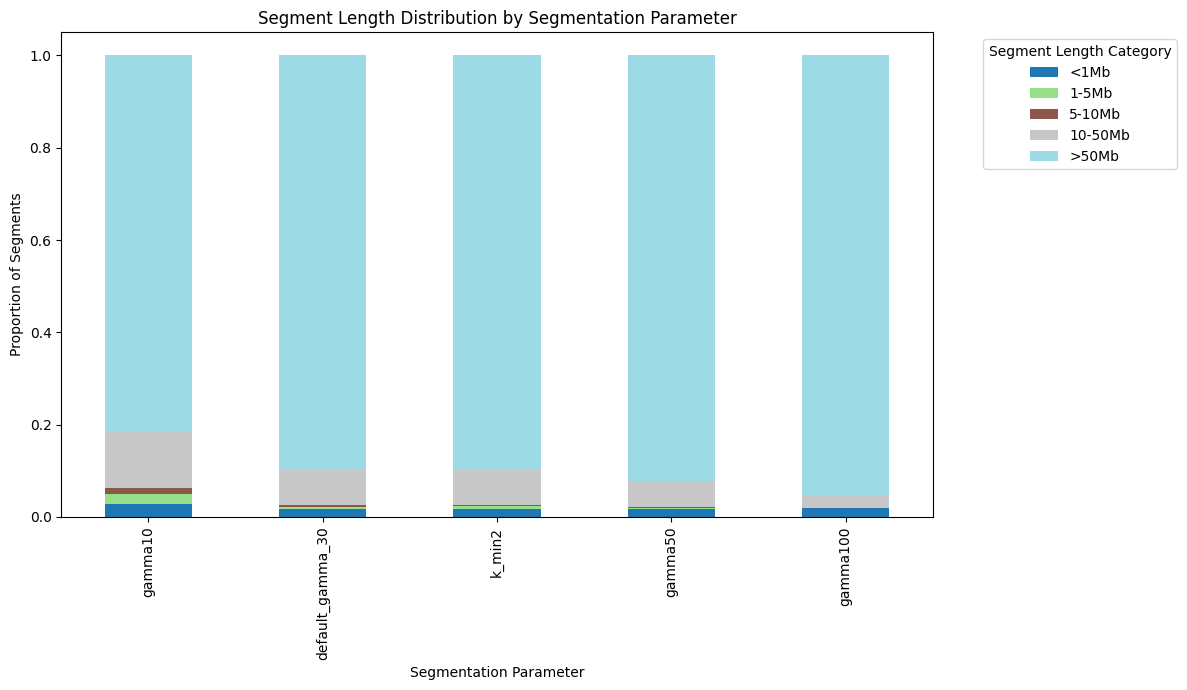

In [66]:
# 2) Stacked bar of segment lengths split by class
all_segs['segment_length'] = all_segs['end'] - all_segs['start']
length_bins = [0, 1_000_000, 5_000_000, 10_000_000, 50_000_000, np.inf]
length_labels = ['<1Mb', '1-5Mb', '5-10Mb', '10-50Mb', '>50Mb']
all_segs['length_category'] = pd.cut(all_segs['segment_length'], bins=length_bins, labels=length_labels)
length_dist = all_segs.groupby(['run', 'length_category']).size().unstack(fill_value=0)
length_dist_norm = length_dist.div(length_dist.sum(axis=1), axis=0)
length_dist_norm.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20')
plt.title('Segment Length Distribution by Segmentation Parameter')
plt.xlabel('Segmentation Parameter')
plt.ylabel('Proportion of Segments')
plt.legend(title='Segment Length Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('segment_length_distribution_stacked_bar.pdf')
plt.show()

/var/folders/bl/y_b3z21x40sfgtztcxdh3zt00000gq/T/ipykernel_62895/1438551551.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_dist = all_segs.groupby(['run', 'copy_number_class'])['segment_length'].sum().unstack(fill_value=0)


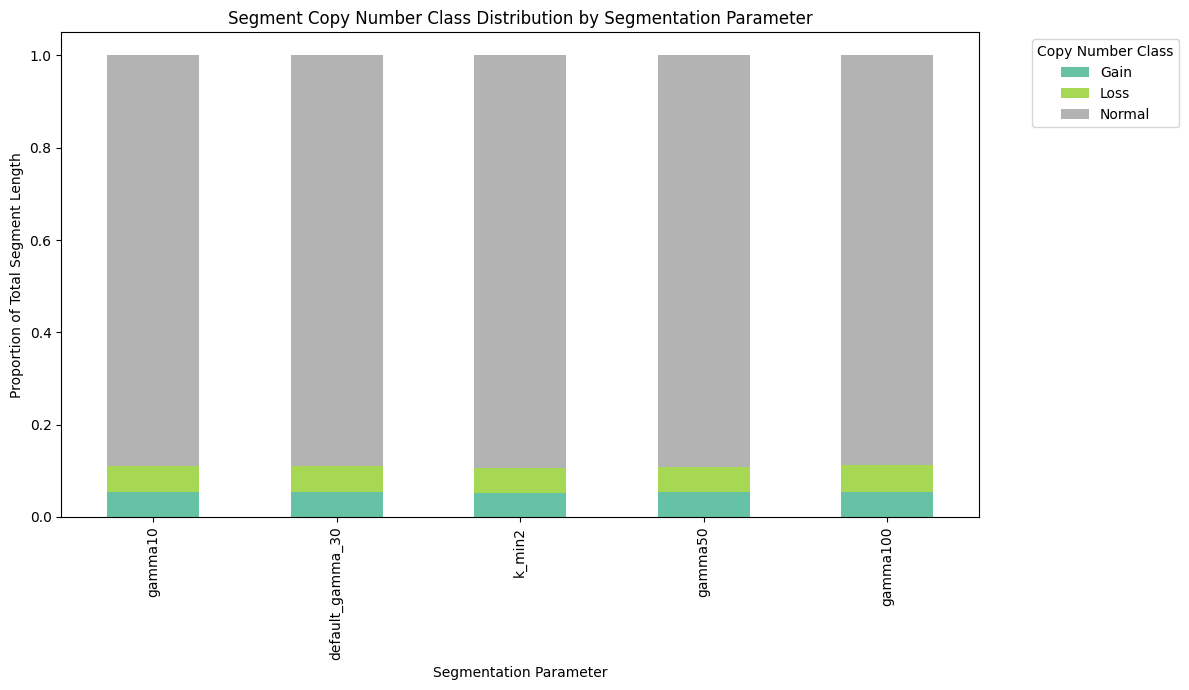

In [67]:
# 3) Stacked bar of segments summed by class (Loss / Normal / Gain)
# all_segs does not have a 'copy_number' column; use the existing 'class' column if present.
# Ensure we create a column named 'copy_number_class' for downstream grouping.

if 'class' in all_segs.columns:
	# Normalize casing and map common labels to desired titles
	all_segs['copy_number_class'] = all_segs['class'].astype(str).str.strip().str.lower().map({
		'loss': 'Loss',
		'normal': 'Normal',
		'gain': 'Gain'
	}).fillna(all_segs['class'].astype(str).str.title())
else:
	# Fallback: approximate class from the 'value' column (log ratio) if no explicit class exists
	# thresholds can be adjusted as needed
	all_segs['copy_number_class'] = pd.cut(
		all_segs['value'],
		bins=[-np.inf, -0.2, 0.2, np.inf],
		labels=['Loss', 'Normal', 'Gain']
	)

# Aggregate total segment length by run and copy number class
class_dist = all_segs.groupby(['run', 'copy_number_class'])['segment_length'].sum().unstack(fill_value=0)

# Normalize to proportions per run
class_dist_norm = class_dist.div(class_dist.sum(axis=1).replace({0: 1}), axis=0)

# Plot stacked bar
class_dist_norm.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set2')
plt.title('Segment Copy Number Class Distribution by Segmentation Parameter')
plt.xlabel('Segmentation Parameter')
plt.ylabel('Proportion of Total Segment Length')
plt.legend(title='Copy Number Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('segment_copy_number_class_distribution_stacked_bar.pdf')
plt.show()
